## Ben Branchflower
## Homework 5
This homework works with some dimensionality reudction and clustering.

In [25]:
from time import time

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score

# to display plots by default
%matplotlib inline

seed = 17 # establishing the seed to be used throughout the code
np.random.RandomState(seed)

# suppressing deprecation warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
mnist = datasets.fetch_mldata("MNIST Original")
X = mnist.data
y = mnist.target

### 1. Use PCA to reduce the dimensionality
a. How many components did you use? Why?

b. Plot the first two components. Do you notice any trends? What is this plot showing us?

c. Why would you use PCA? What is it doing? And what are the drawbacks?  

Reducing the dimensionality can be kind of touchy as we want to keep the variation that gives us predictive power but we do not want to keep all of the variables. I will plot the amount of variation that we get from different amounts of variables to see where we can get some of both.

95% of variation comes from first 154 components


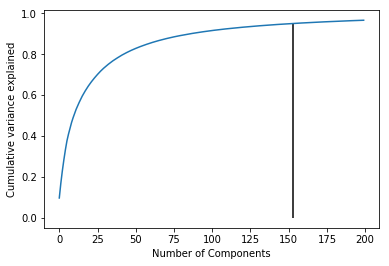

In [3]:
pca = PCA(n_components=200, random_state=seed)
X_pca = pca.fit_transform(X)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)
n_comp = [i for i, r in enumerate(cum_ratio) if r > 0.95][0] # getting the components that give 95% variation
change_var = [r - cum_ratio[i-1] if i != 0 else 0 for i, r in enumerate(cum_ratio)]
chg_chg = [r - change_var[i-1] if i != 0 else 0 for i, r in enumerate(change_var)]
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.vlines(ymin=0,ymax=cum_ratio[n_comp],x=n_comp)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative variance explained")
print(f'95% of variation comes from first {n_comp + 1} components')

#### a. How many components did you use? Why?
I will use 154 components as those components contain 95% of the variation in the data. That is nearly all of the variation that we get from the full set of variables but we have many fewer. 

In [4]:
pca = PCA(n_components=0.95) # using n components that give 95% variation
X_pca = pca.fit_transform(X)
X_pca.shape

(70000, 154)

This method of just selecting the point that gives use 95% variation also tells us 154 components so the calculations I made match up with the ones that scikitlearn uses for that.

#### b. Plot the first two componenet. Do you notice any trends? What is the plot showing us?

Text(30.2276,0.5,'2nd Principal Component')

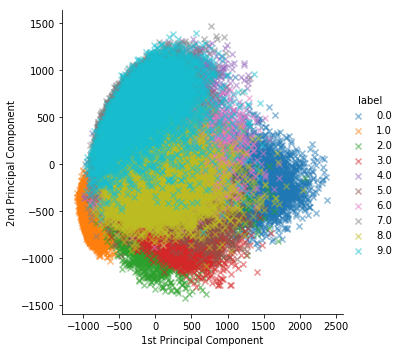

In [5]:
pca_ = PCA(n_components=2)
princ_comp = pca_.fit_transform(X)
princ_df = pd.DataFrame(princ_comp, columns=['comp1', 'comp2'])
princ_df['label'] = y
sns.lmplot(x='comp1', y='comp2', data=princ_df, hue='label', fit_reg=False, markers='x',
          scatter_kws={'alpha':'0.5'})
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')

The first component has a much wider range than the second componenet which makes sense as it is the one that maximizes variance and the second one gets as much variance given the first component so there is less variance for it to get. It is difficult to differentiate from one group to the other so variance may be maximized but it isn't necessarily helping us get to identifying which group is which.

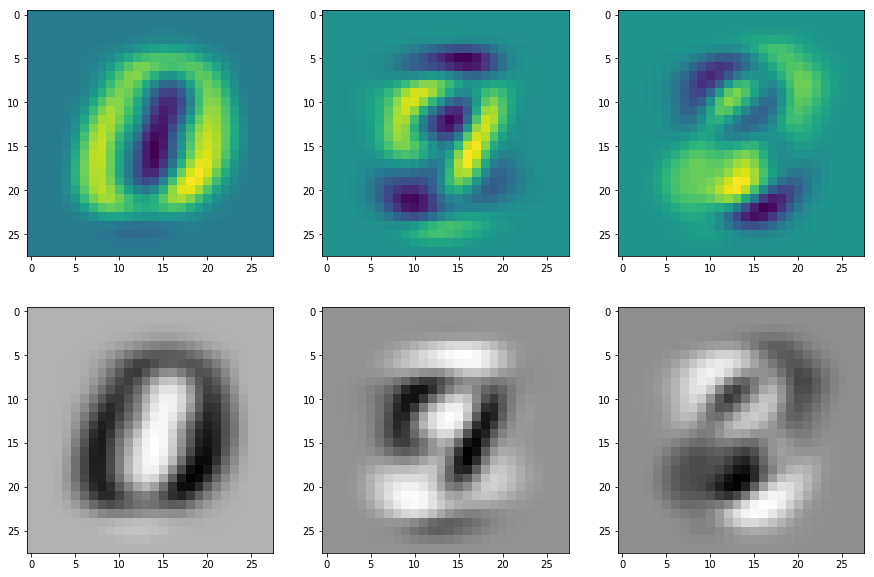

In [6]:
f, ax = plt.subplots(2,3, figsize=(15,10))
ax[0][0].imshow(pca.components_[0].reshape(28,28))
ax[0][1].imshow(pca.components_[1].reshape(28,28))
ax[0][2].imshow(pca.components_[2].reshape(28,28))
ax[1][0].imshow(pca.components_[0].reshape(28,28), cmap='Greys')
ax[1][1].imshow(pca.components_[1].reshape(28,28), cmap='Greys')
ax[1][2].imshow(pca.components_[2].reshape(28,28), cmap='Greys')

The coloured ones just look cool so I kept them.  
The variation in the first component seems to look like a 0 pretty clearly. The second component seems to be getting less clear which makes sense because a lot of the variace is soaked up in the first one. So after the first ones then the components produced by pca are not helpful in determining what the picture is.
#### c. Why would you use PCA? What is it doing? And what are the drawbacks?
PCA would be a good way to reduce dimensions if the interpretablity is not important. So if all we are worried about is predictive power then PCA might be a good way to reduce some overfitting from having a large number of variables while still getting a lot of the variance.  
It is finding the axes that maximize the variance that are made up of linear combinations of the variables. The nth component maximizes variance given the n-1th component.
It is really hard to understand the results after reducing them so that is quite a drawback and the plot of the two components shows that it is really difficult to differentiate the groups even though the variance is maximaized.
#### d. Plot some of the images, then compress them using PCA and plot again. How does it look?

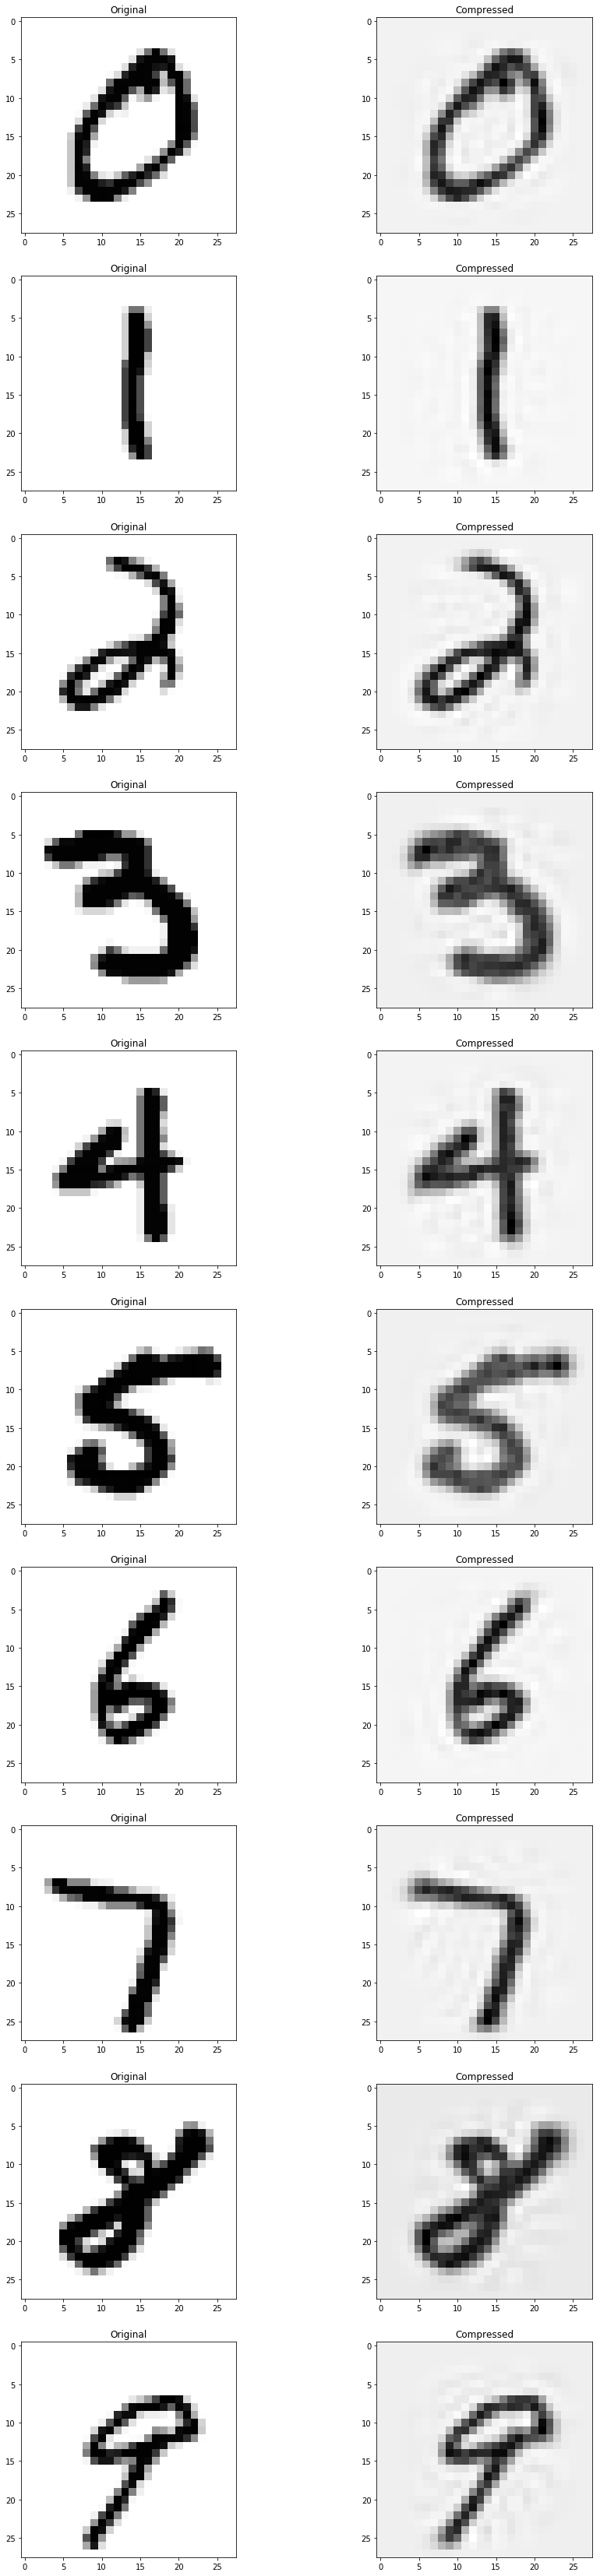

In [7]:
approximation = pca.inverse_transform(X_pca)
nrows = 10
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(15,60))
for r, image in enumerate([i*6500 for i in range(nrows)]):
    axes[r][0].imshow(X[image].reshape((28,28)), cmap='Greys')
    axes[r][0].set_title('Original')
    axes[r][1].imshow(approximation[image].reshape((28,28)), cmap='Greys')
    axes[r][1].set_title('Compressed')

The compressed image seems to be a little blurrier than the original but you can tell what the numbers are just as well as the original image.

### 2. Use t-SNE to plot the first two components (you should probably random sample around 10000 points):

a. How does this plot differ from your PCA plot?

b. How robust is it to changes in perplexity?

c. How robust is it to different learning rate and number of iterations?

In [8]:
rows = np.random.randint(low=0, high=X.shape[0], size = 1000) # to reduce runtime

In [9]:
def tsne(n_components=2, perplexity=50, n_iter=1000, learning_rate=200, verbose=1,
        random_state=seed):
    """This function uses tSNE dimensionality reduction and creates a dataframe ready to plot"""
    tsne_ = TSNE(n_components=n_components, verbose=verbose, perplexity=perplexity,
                 n_iter=n_iter, learning_rate=learning_rate, random_state=seed)
    tsne_results = tsne_.fit_transform(X[rows])
    df_tsne = pd.DataFrame(tsne_results, columns=['comp1', 'comp2'])
    df_tsne['label'] = y[rows]
    return df_tsne

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.139s...
[t-SNE] Computed neighbors for 1000 samples in 1.343s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 665.771169
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.453011
[t-SNE] KL divergence after 1000 iterations: 1.000337


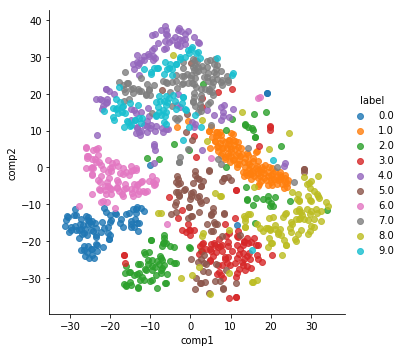

In [10]:
sns.lmplot(x='comp1', y='comp2', data=tsne(), hue='label', fit_reg=False)

#### a. How does this plot differ from your PCA plot?
The groups seem to be more distinct in the plot fo the tSNE dimensionality reduction. The PCA plots are not as clear in differentiating between groups as many of them are stacked on top of eachother.  
#### b. How robust is it to changes in perplexity?
I will plot the results of reduction with some different values for the perplexity hyperparameter to visualize how different they are. If they are similar then it is robust to changes in perplexity.

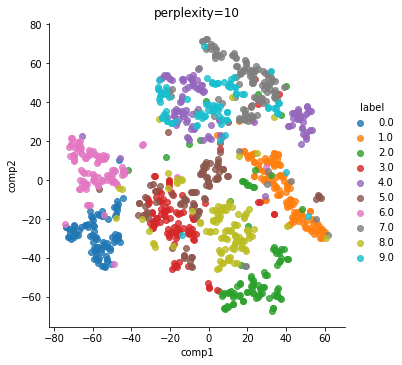

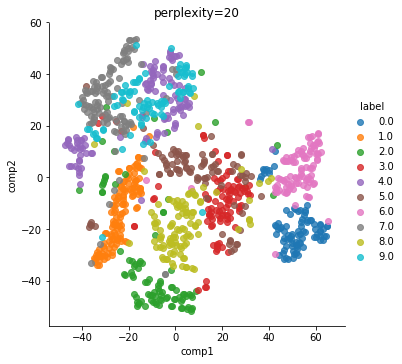

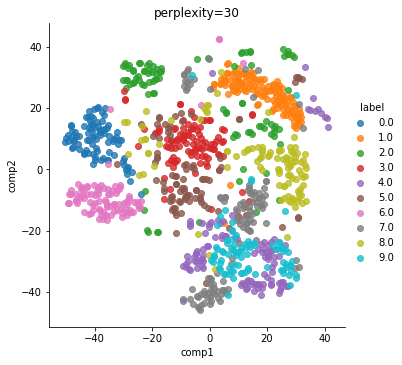

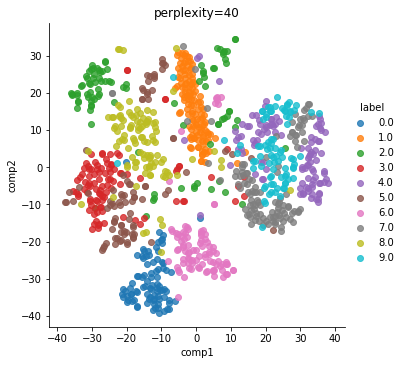

In [11]:
for p in [10,20,30,40]:
    sns.lmplot(x='comp1', y='comp2', data=tsne(perplexity=p, verbose=0), hue='label', fit_reg=False)
    plt.title(f'perplexity={p}')

The plots seem to be rather different. It is interesting because the documentation says that it shouldn't be incredibly important to the results but we are seeing pretty significant changes. This likely has something to so with the number of points that we are using but once again I can't really increase that a whole lot without my computer having really trouble with it.

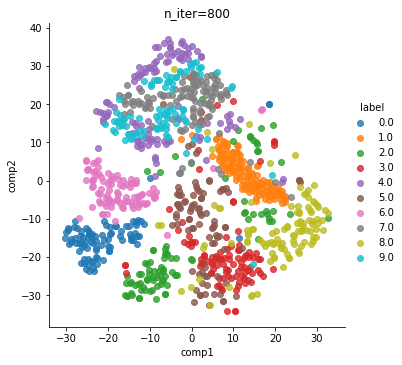

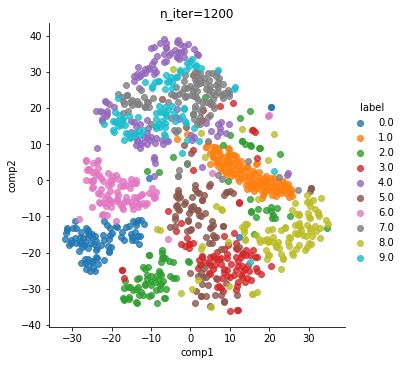

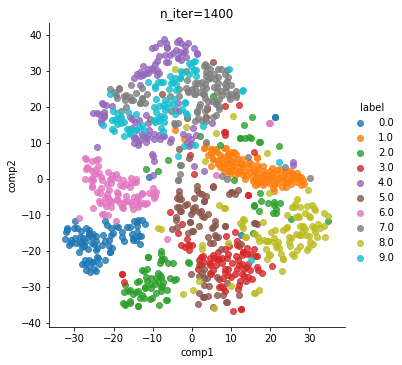

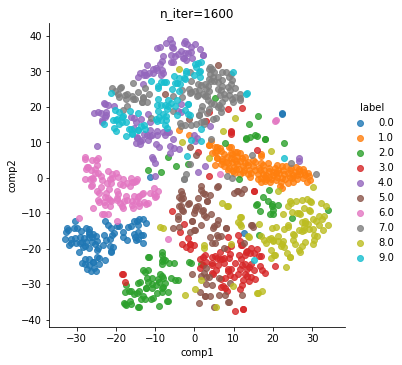

In [12]:
for i, n in enumerate([800,1200,1400,1600]):
    sns.lmplot(x='comp1', y='comp2', data=tsne(n_iter=n, verbose=0), hue='label', fit_reg=False)
    plt.title(f'n_iter={n}')

The number of iterations doesn't seem to change much at all. I would have assumed that it would be mor eimportant than perplexity but maybe the smaller number of data points is causing this.

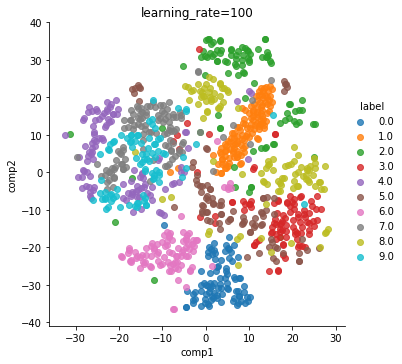

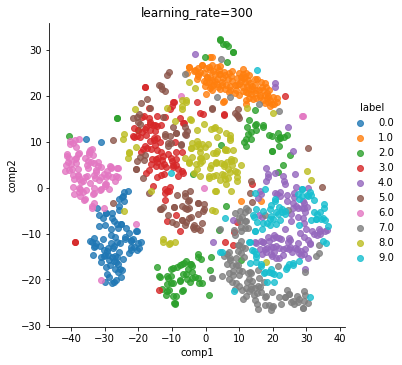

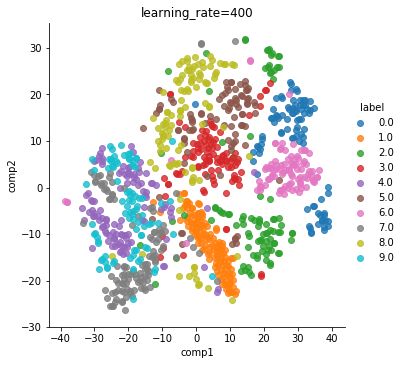

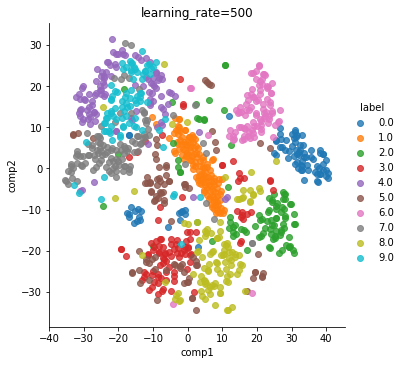

In [13]:
for i, l in enumerate([100,300,400,500]):
    sns.lmplot(x='comp1', y='comp2', data=tsne(learning_rate=l, verbose=0), hue='label', fit_reg=False)
    plt.title(f'learning_rate={l}')

Learning rate seems to have a pretty significant effect on the results. The lower learning rate seems to do the best job of getting the groups cleanly separated which makes sense as the larger values in learning rate could cause the algorithm to jump over the ideal spots.

# K-Means
a. How did you choose k?

b. How did you evaluate your clustering?

c. Visualize your clusters using t-sne


d. Did you scale your data?


e. How robust is your clustering?



In [14]:
def kmeans_predict(n_clusters=10, n_init=50, n_jobs=-1, max_iter=300, all_rows=False):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, n_jobs=n_jobs, max_iter=max_iter)
    if not all_rows:
        kmeans.fit(X[rows])
        return kmeans.predict(X[rows])
    else:
        kmeans.fit(X)
        return kmeans.predict(X)

#### a. How did you choose k?
I picked 10 because the are ten numbers 0-9. It doesn't really make sense to do anything but 10 in this case where we know the number of groups. It would be harder to say if I didn't know that beforehand.
#### b. How did you evaluate your clustering?
The adjusted Rand index is osmething that we can sue as we have the true labels. We often can't use this with clustering but the true labels allow us to use this method. Another method that we can use is the silhouette score.

In [23]:
adjusted_rand_score(y[rows], kmeans_predict())

0.3902992353114878

In [26]:
kmeans_model = KMeans(n_clusters=10, n_init=50, n_jobs=-1, max_iter=300).fit(X[rows])
labels = kmeans_model.labels_
silhouette_score(X[rows], labels, metric='euclidean')

0.05688011532398269

So it looks like we are doing alright from the rand score but the silhouette score is saying we are doing slightly better than random assignment. It is good that we have a positive number but it isn't looking fantastic for us.

#### c. Visualize your clusters using t-sne

Text(0.5,1,'Original Labels')

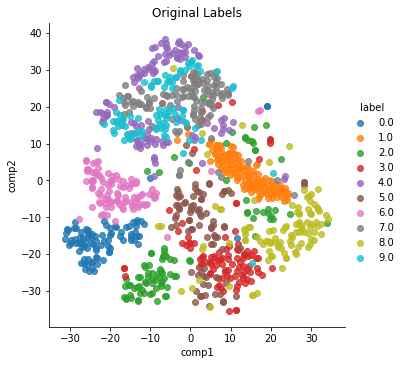

In [16]:
# use predicted values as labels and use those on the already reduced data
out = tsne(verbose=0)
sns.lmplot(x='comp1', y='comp2', data=out, hue='label', fit_reg=False)
plt.title("Original Labels")

Text(0.5,1,'kMeans predicted Labels')

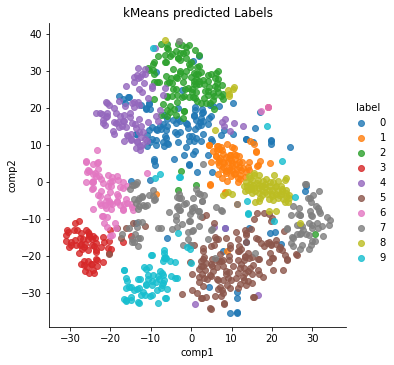

In [17]:
out['label'] = kmeans_predict()
sns.lmplot(x='comp1', y='comp2', data=out, hue='label', fit_reg=False)
plt.title("kMeans predicted Labels")

#### d. Did you scale your data?
No, the data is all in the same scale already as the magnitude of each entry being the darkness of the pixel in the location that corresponds to that place in the array. On top of all that, I don't want to ruin the mess up the variation that is contained in that by scaling the data. 

#### e. How robust is your clustering? 
Let's vary n_init and the number of data points that it gets to check the robustness of the clustering. We can compare the graphs of each and see if they change much

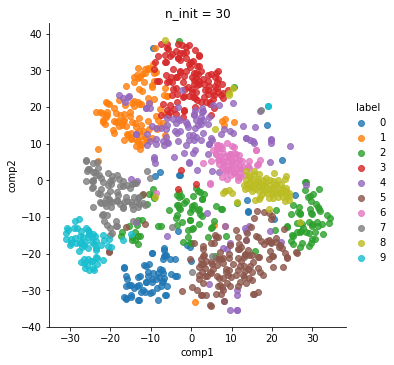

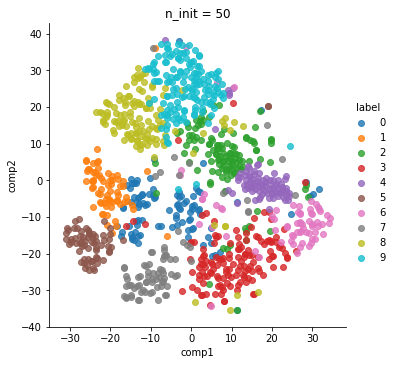

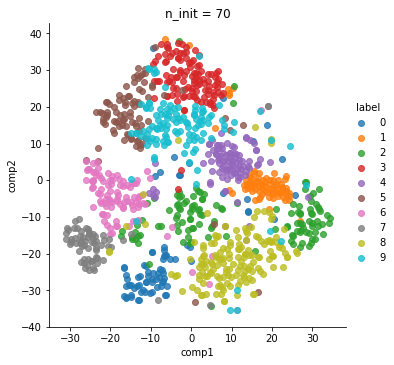

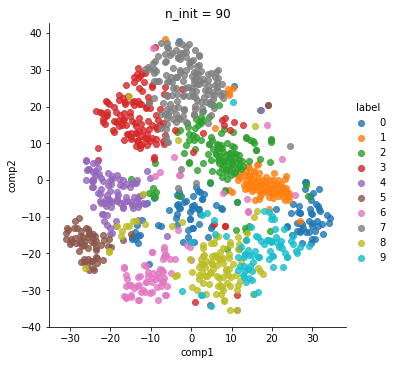

In [18]:
for n in [30, 50, 70, 90]:
    out['label'] = kmeans_predict(n_init=n)
    sns.lmplot(x='comp1', y='comp2', data=out, hue='label', fit_reg=False)
    plt.title(f"n_init = {n}")

Based on these images it appears that the clustering is fairly robust to the hyperparameter n_init as the groups are comparable in each of the images.

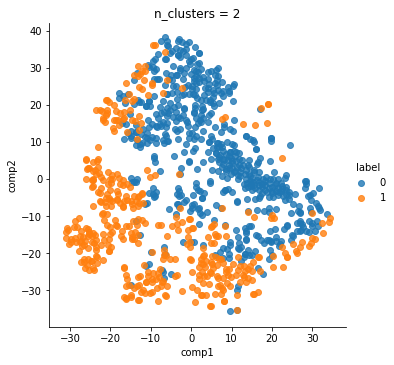

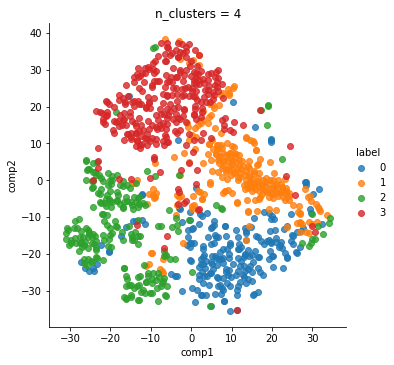

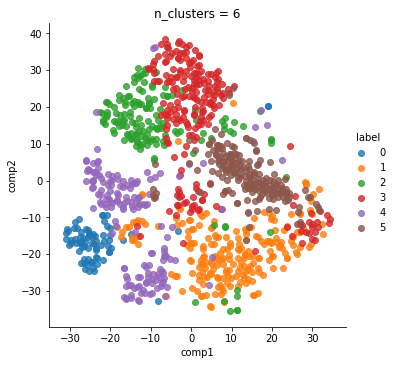

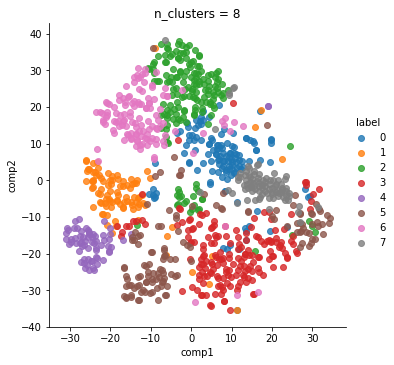

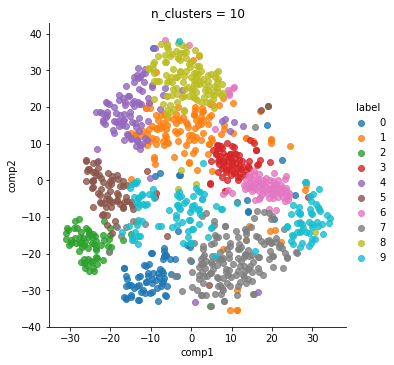

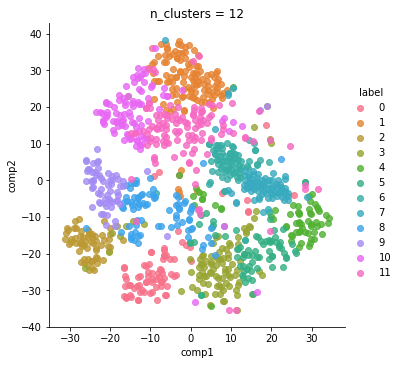

In [30]:
for k in range(2,14,2):
    out['label'] = kmeans_predict(n_clusters=k)
    sns.lmplot(x='comp1', y='comp2', data=out, hue='label', fit_reg=False)
    plt.title(f"n_clusters = {k}")

Based on these I think that it definitely justfiies at least 8 groups if we didn't know how many there wer as it separates them pretty nicely after that. 12 starts looking like too much in the way of clusters so that is comforting as we know 10 is the right amount and 10 is in that range of 8-12

# Heriarchical Clustering
a. Plot your dendrogram

b. How many clusters seem reasonable based off your graph?

c. How does your dendrogram change with different linkage methods?

In [56]:
rows = np.random.randint(low=0, high=X.shape[0], size=100) # to reduce runtime
def dendro(method):
    """make a dendrogram of hierarchical clustering with the specified method"""
    Z = linkage(X[rows], method)
    plt.figure(figsize=(20, 12))
    _ = dendrogram(Z)

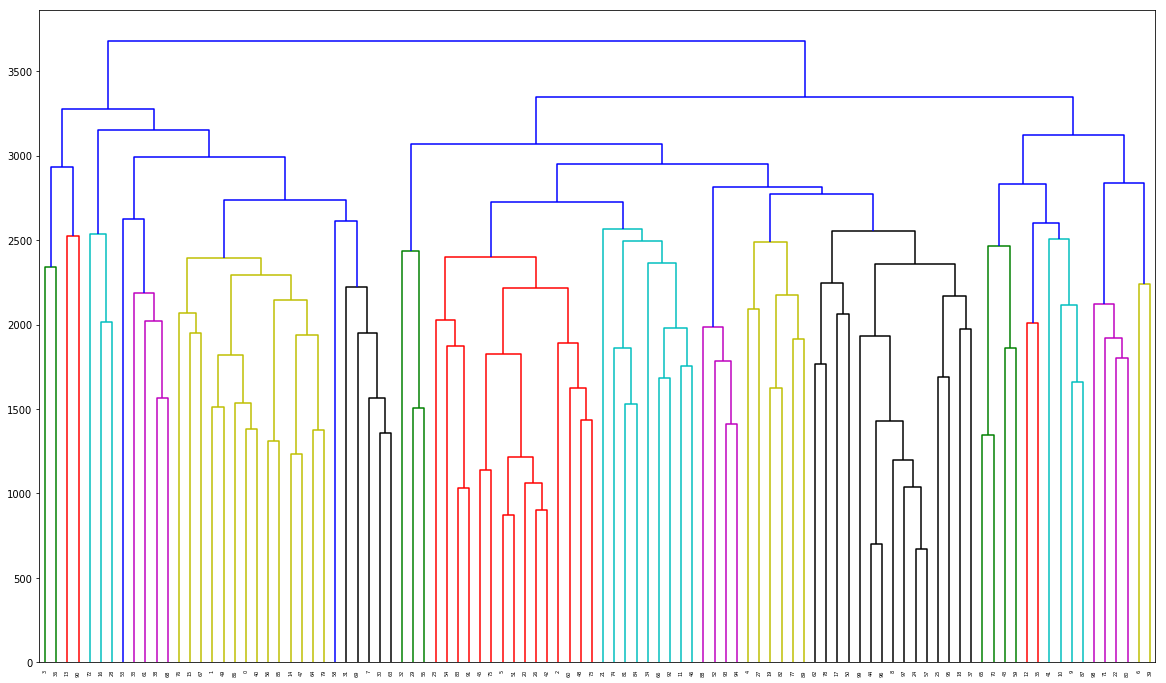

In [57]:
dendro('complete')

It seems like 10-15 would be appropriate from this one

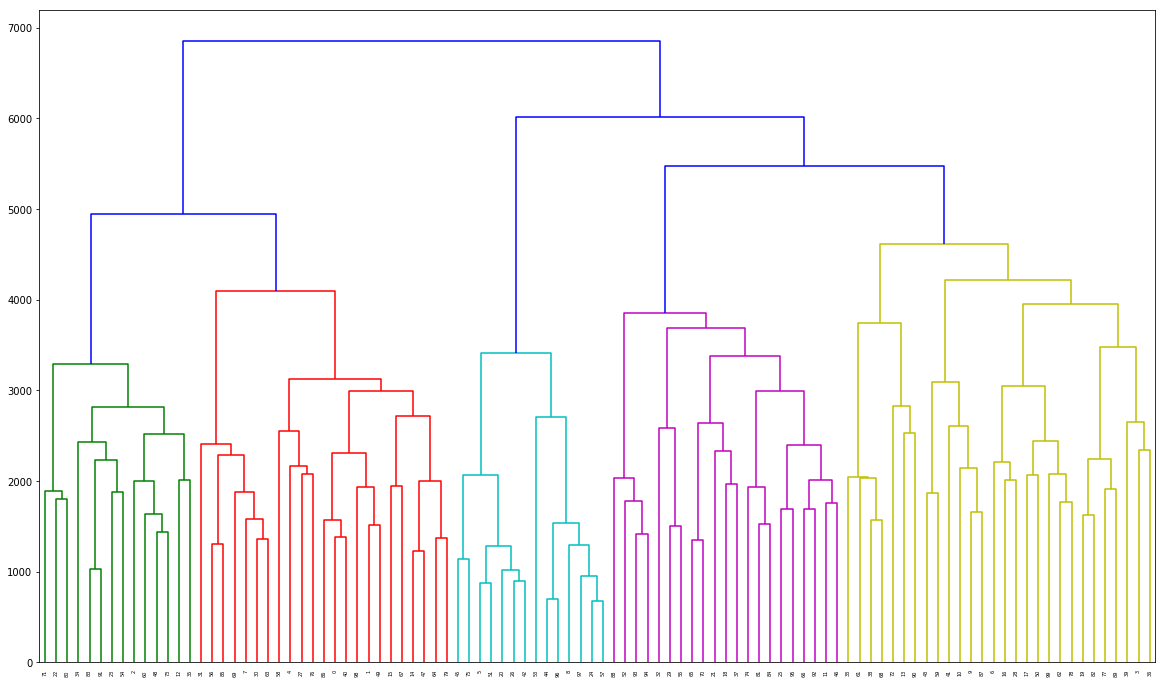

In [58]:
dendro('ward')

It seems like 5 groups would be the best way using this metric

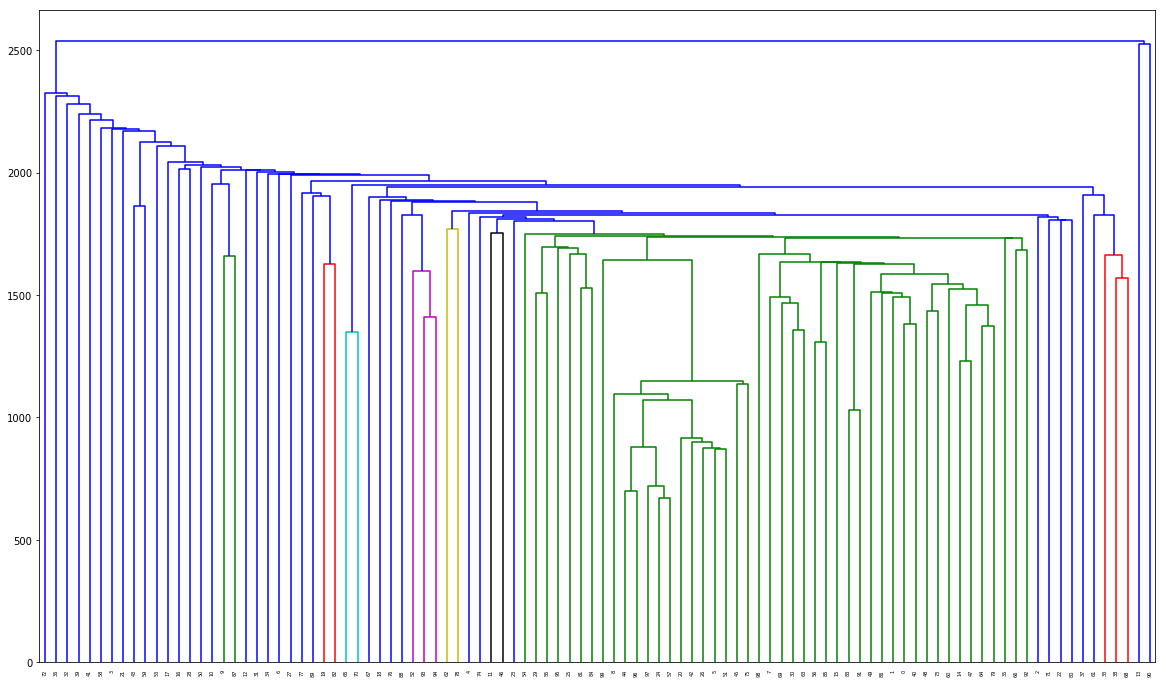

In [59]:
dendro('single')

This is a big mess and I would say that I just wouldn't use this linkage method so I won't worry about the number of clusters.

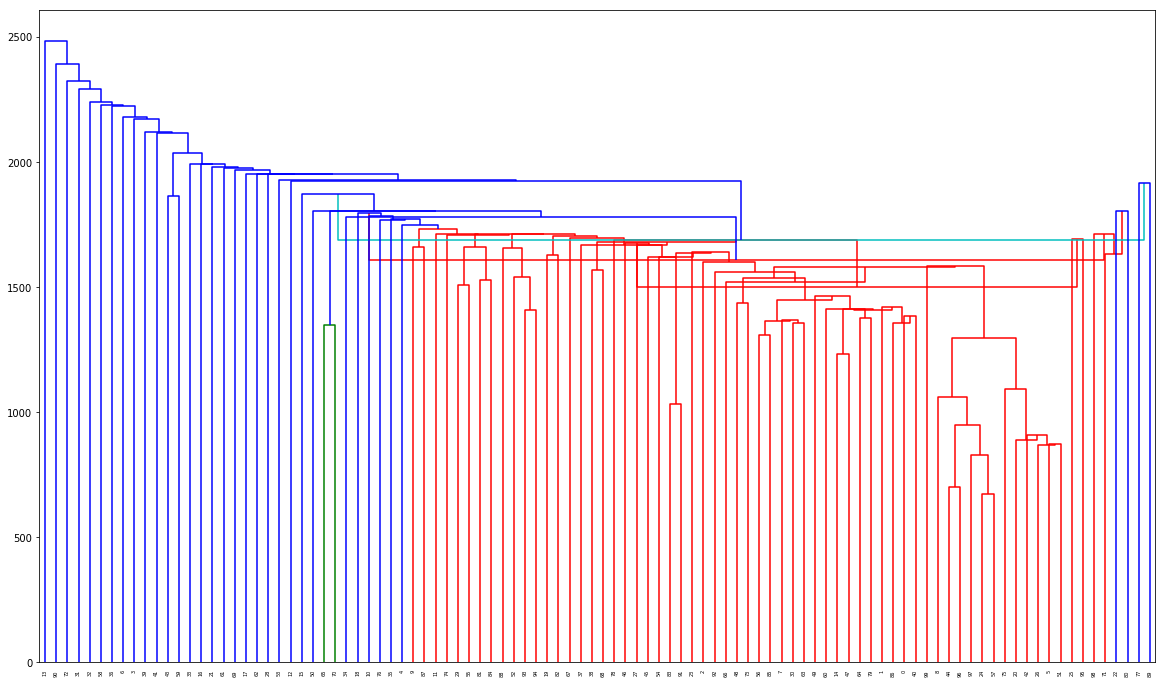

In [60]:
dendro('centroid')

Same as above this doesn't seem to be incredibly informative
#### b. How many clusters seem reasonable based off your graph?
The Ward linkage method gives us the neatest separation but the complete linkage method implies more than the five that are in that shown in that dendrogram. Because I know that there are actually 10 groups I want to say that but the picture is telling me something around 7 or 8 if I didn't know that there are 10 groups. 

#### c. How does your dendrogram change with different linkage methods?  
It was surprising to see how different the clusters were from the different linkage methods. It is likely in part due to the relatively small number of points that I am using as I would expect them to be relatively comparable with different linkage methods with a larger sample that I can't really justify based on the runtime and the visualization losing value with higher numbers of points.